## 2025 CVE Data

In [1]:
%%capture
#!rm *.jsonl 
#!wget -q https://nvd.handsonhacking.org/nvd.jsonl

In [2]:
# Import necessary libraries
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
from datetime import date
import calplot
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Register a cell magic for Markdown
@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))

# Configure logging and warnings
logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")

# Set pandas display options
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [ ]:
def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)
nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2025-01-01') & (nvd['Published']  < '2025-5           s-01'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2025, 1, 1)
enddate  = date(2025, 5, 1)
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days


In [4]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **16017**<br />Average CVEs Per Day: **133.48**<br />Average CVSS Score: **6.58**

In [5]:
Markdown(f"## CVE Graphs")

## CVE Graphs

In [6]:
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')

In [7]:
Markdown(f"### CVE Calendar")

### CVE Calendar

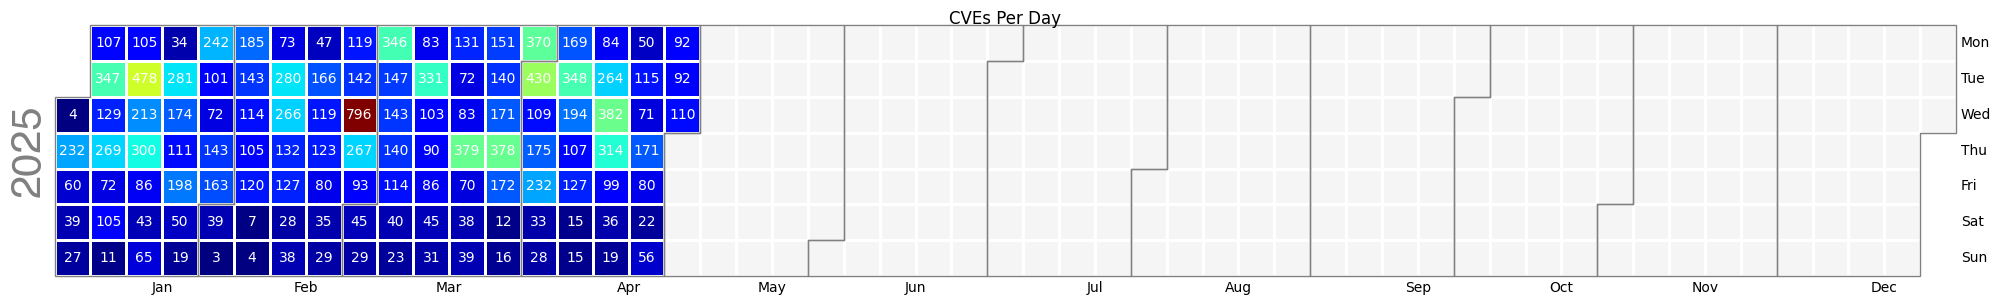

In [8]:
dfs = nvd['Published'].apply(lambda x: pd.to_datetime(x, errors='coerce', format='%Y/%m/%d'))
df = dfs.value_counts()
df = df.to_frame()
df.index = df.index.strftime('%m/%d/%Y')
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')
calplot.calplot(df.T.squeeze(), cmap='jet', dropzero=True, edgecolor="Grey", textcolor="White", textformat='{:.0f}', textfiller='', suptitle='CVEs Per Day', figsize=(25,3));

#### Per Month

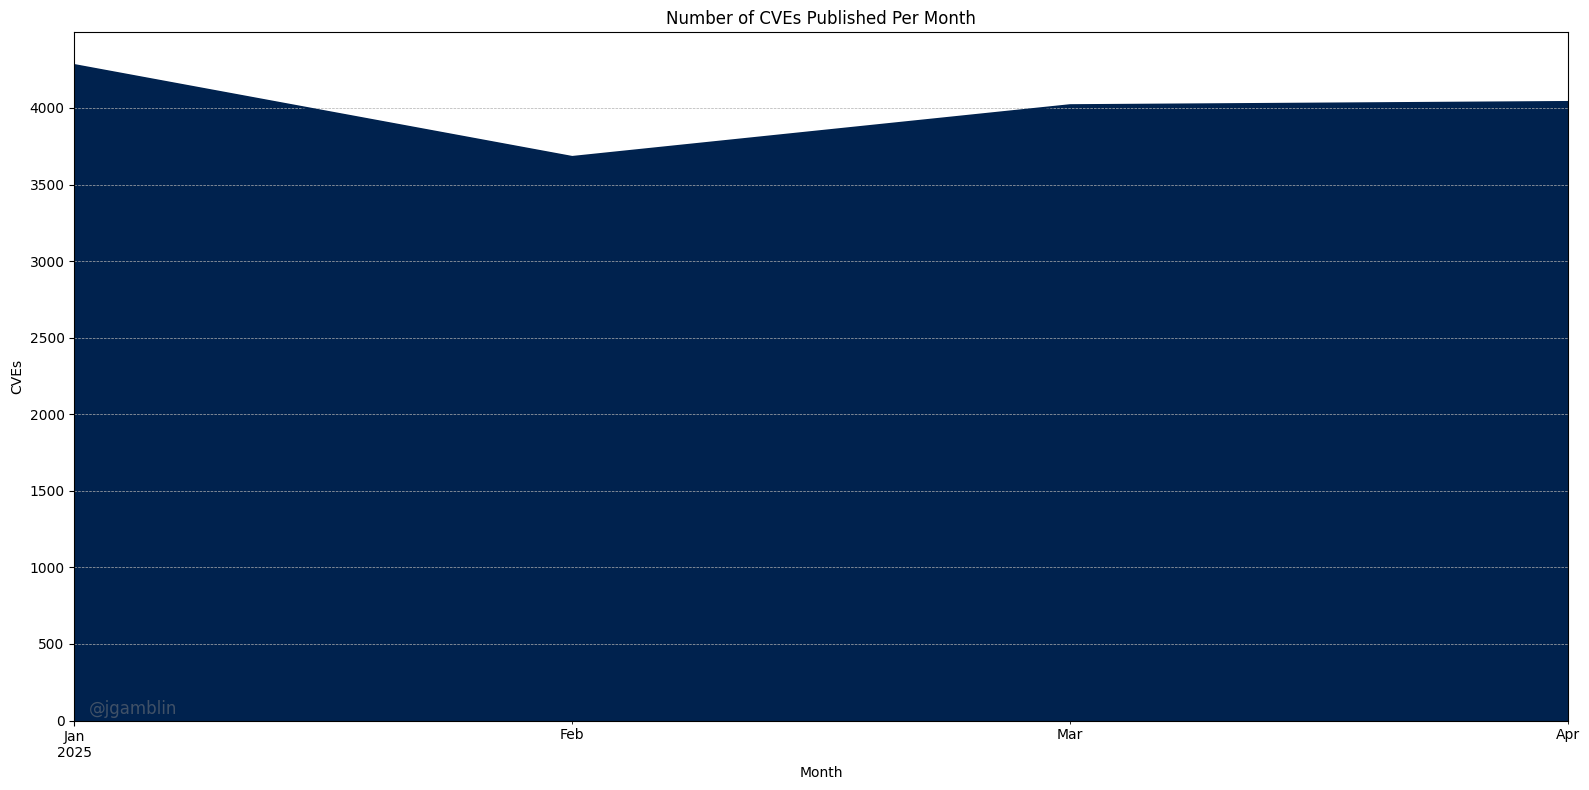

In [9]:
cg = Month_Graph.plot.area(colormap='cividis', figsize=(16, 8), title='Number of CVEs Published Per Month')
plt.grid(True, linestyle='--', linewidth=0.5)
cg.set_ylabel("CVEs")
cg.set_xlabel("Month")

# Add watermark
plt.text(0.01, 0.01, '@jgamblin', transform=cg.transAxes, fontsize=12, color='gray', alpha=0.5)

# Adjust layout and save the chart as a PNG file one directory up
plt.tight_layout()
plt.show()

In [10]:
Markdown(f"### CVE Per Week Graph")

### CVE Per Week Graph

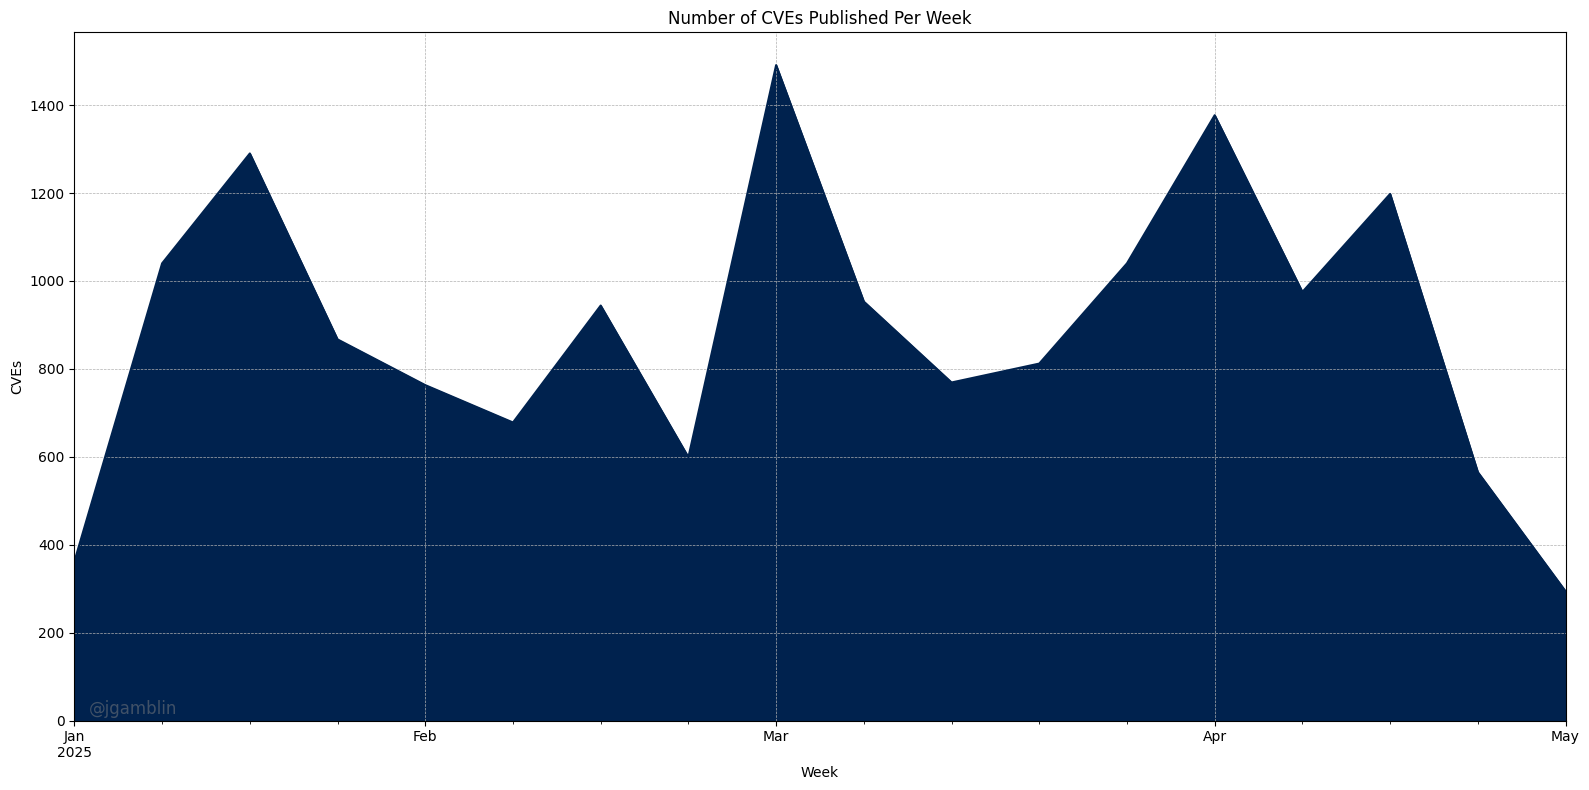

In [11]:
cg = Week_Graph.plot.area(colormap='cividis', figsize=(16, 8), title='Number of CVEs Published Per Week')
plt.grid(True, linestyle='--', linewidth=0.5)
cg.set_ylabel("CVEs")
cg.set_xlabel("Week")

# Add watermark
plt.text(0.01, 0.01, '@jgamblin', transform=cg.transAxes, fontsize=12, color='gray', alpha=0.5)

# Adjust layout and save the chart as a PNG file one directory up
plt.tight_layout()

plt.show()

In [12]:
Markdown(f"### CVE Per Day Graph")

### CVE Per Day Graph

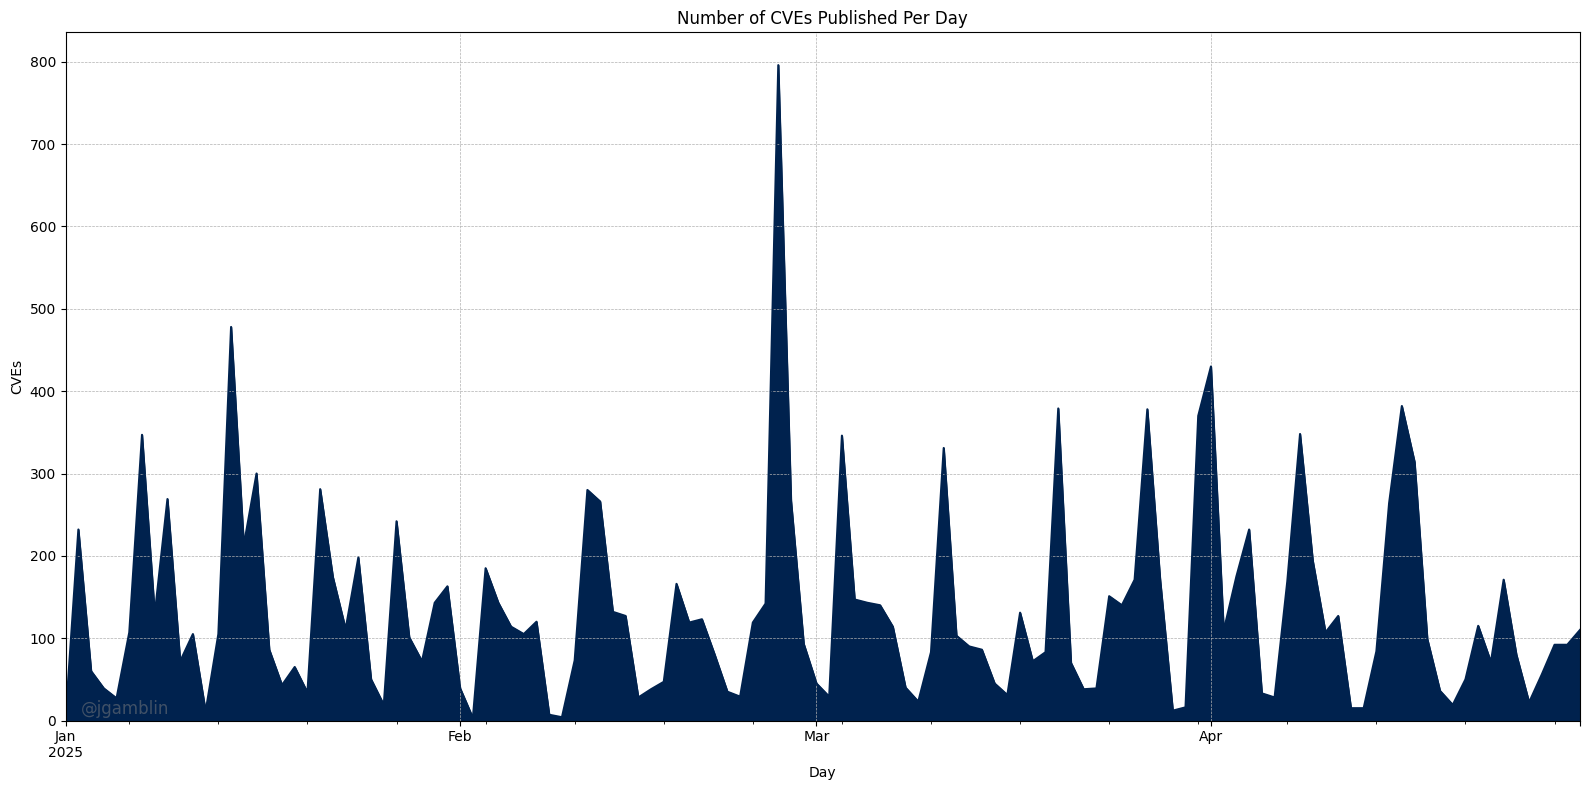

In [13]:
cg = Day_Graph.plot.area(colormap='cividis', figsize=(16, 8), title='Number of CVEs Published Per Day')
plt.grid(True, linestyle='--', linewidth=0.5)
cg.set_ylabel("CVEs")
cg.set_xlabel("Day")

# Add watermark
plt.text(0.01, 0.01, '@jgamblin', transform=cg.transAxes, fontsize=12, color='gray', alpha=0.5)

# Adjust layout and show the chart
plt.tight_layout()
plt.show()

In [14]:
Markdown(f"## CVSS Data")

## CVSS Data

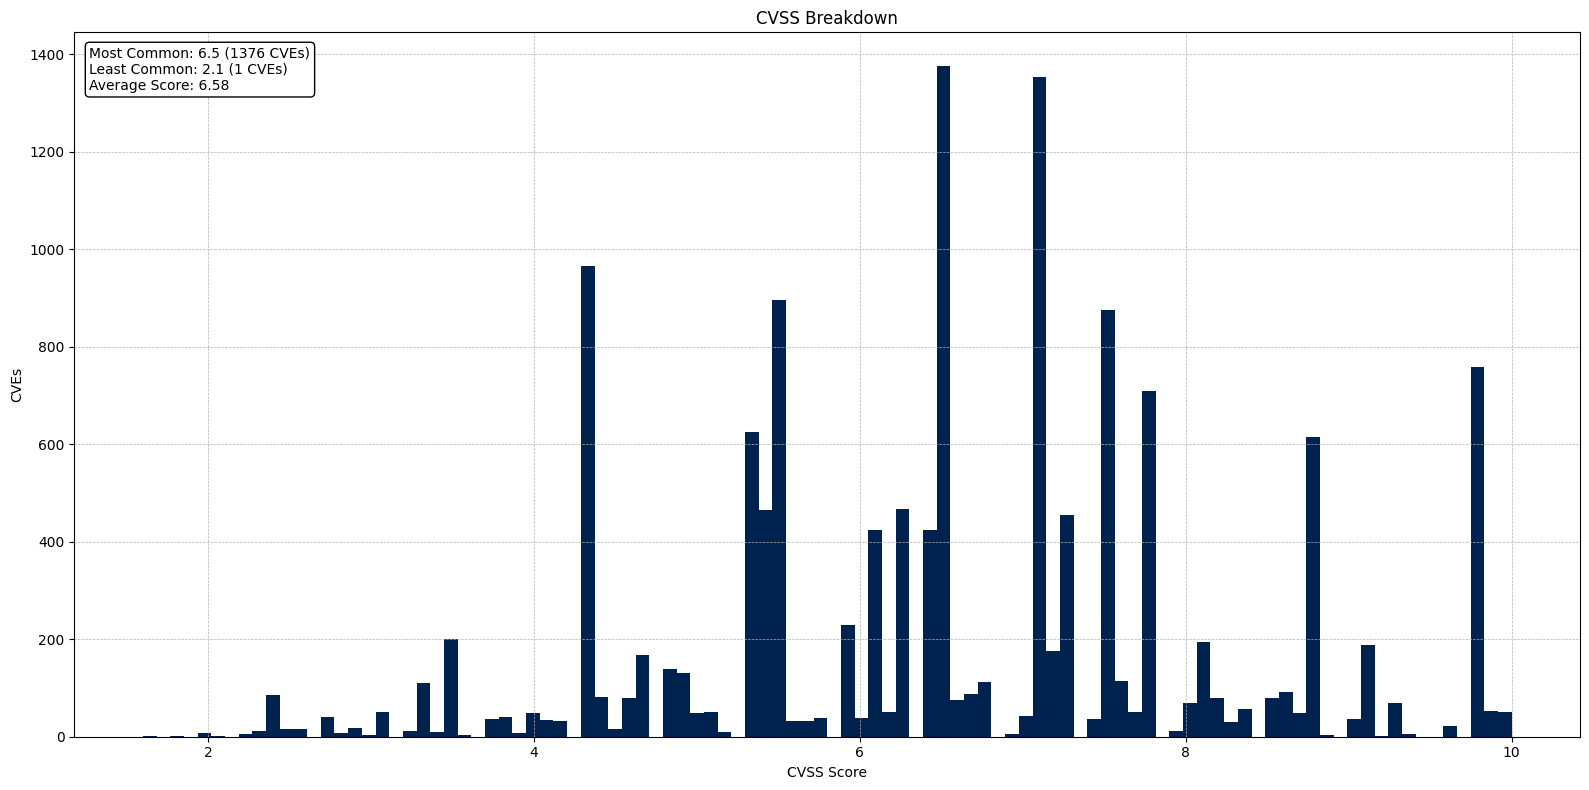

In [15]:
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore'])
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan)

# Plot the CVSS breakdown with 100 bins
cg = nvd['BaseScore'].plot(kind="hist", bins=100, title='CVSS Breakdown', colormap='cividis', figsize=(16, 8))
plt.grid(True, linestyle='--', linewidth=0.5)
cg.set_ylabel("CVEs")
cg.set_xlabel("CVSS Score")

# Find the most common, least common, and average CVSS scores
most_common_score = nvd['BaseScore'].mode()[0]
least_common_score = nvd['BaseScore'].value_counts().idxmin()
most_common_count = nvd['BaseScore'].value_counts().max()
least_common_count = nvd['BaseScore'].value_counts().min()
average_score = nvd['BaseScore'].mean().round(2)

# Add annotation for the most common, least common, and average CVSS scores
annotation_text = (f'Most Common: {most_common_score} ({most_common_count} CVEs)\n'
                   f'Least Common: {least_common_score} ({least_common_count} CVEs)\n'
                   f'Average Score: {average_score}')
plt.text(0.01, 0.98, annotation_text, transform=cg.transAxes, fontsize=10, color='black',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# Adjust layout and save the chart as a PNG file one directory up
plt.tight_layout()
plt.show()

In [16]:
Markdown(f"## CNA Data")

## CNA Data

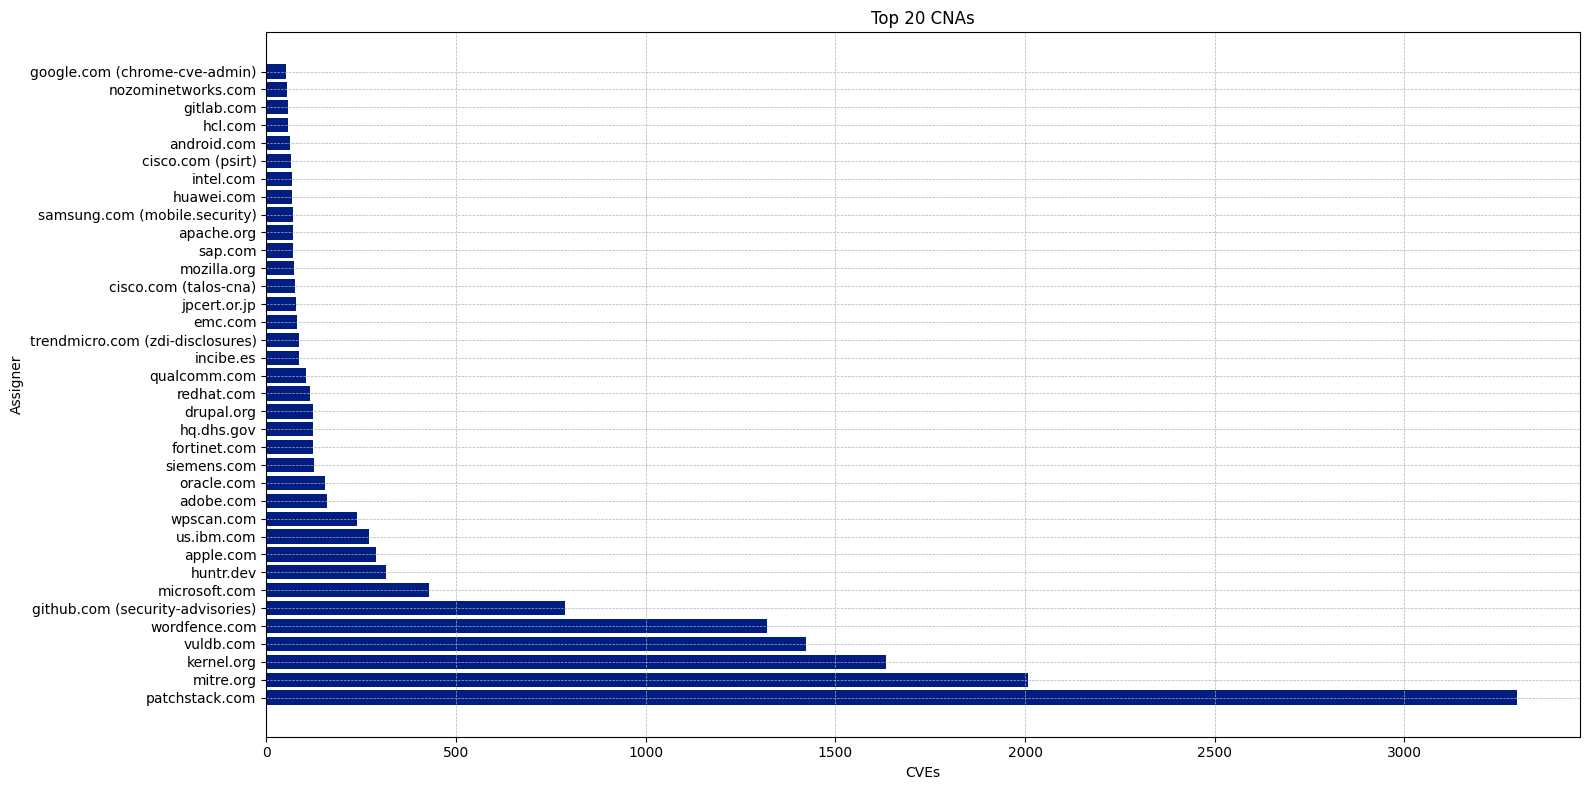

In [17]:
import matplotlib.pyplot as plt

# Replace specific assigner ID with email
nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8c081fb06d67', 'cve@kernel.org', inplace=True)

# Extract domain names and check for uniqueness
nvd['Domain'] = nvd['Assigner'].apply(lambda x: x.split('@')[-1])
domain_counts = nvd['Domain'].value_counts()

# Modify Assigner column based on domain uniqueness
unique_domains = nvd.groupby('Domain')['Assigner'].nunique()
nvd['Assigner'] = nvd.apply(lambda x: x['Domain'] if unique_domains[x['Domain']] == 1 else f"{x['Domain']} ({x['Assigner'].split('@')[0]})", axis=1)

# Calculate frequency of assigners
nvd_frequency = nvd['Assigner'].value_counts().reset_index()
nvd_frequency.columns = ['Assigner', 'counts']
nvd_frequency = nvd_frequency[nvd_frequency.counts > 50].head(50)

# Plot the top 20 CNAs
plt.figure(figsize=(16, 8))
plt.barh("Assigner", "counts", data=nvd_frequency, color="#001d82")
plt.xlabel("CVEs")
plt.ylabel("Assigner")
plt.title("Top 20 CNAs")
plt.grid(True, linestyle='--', linewidth=0.5)

# Adjust layout and show the chart
plt.tight_layout()
plt.show()

In [18]:
Markdown(f"## CWE Data")

## CWE Data

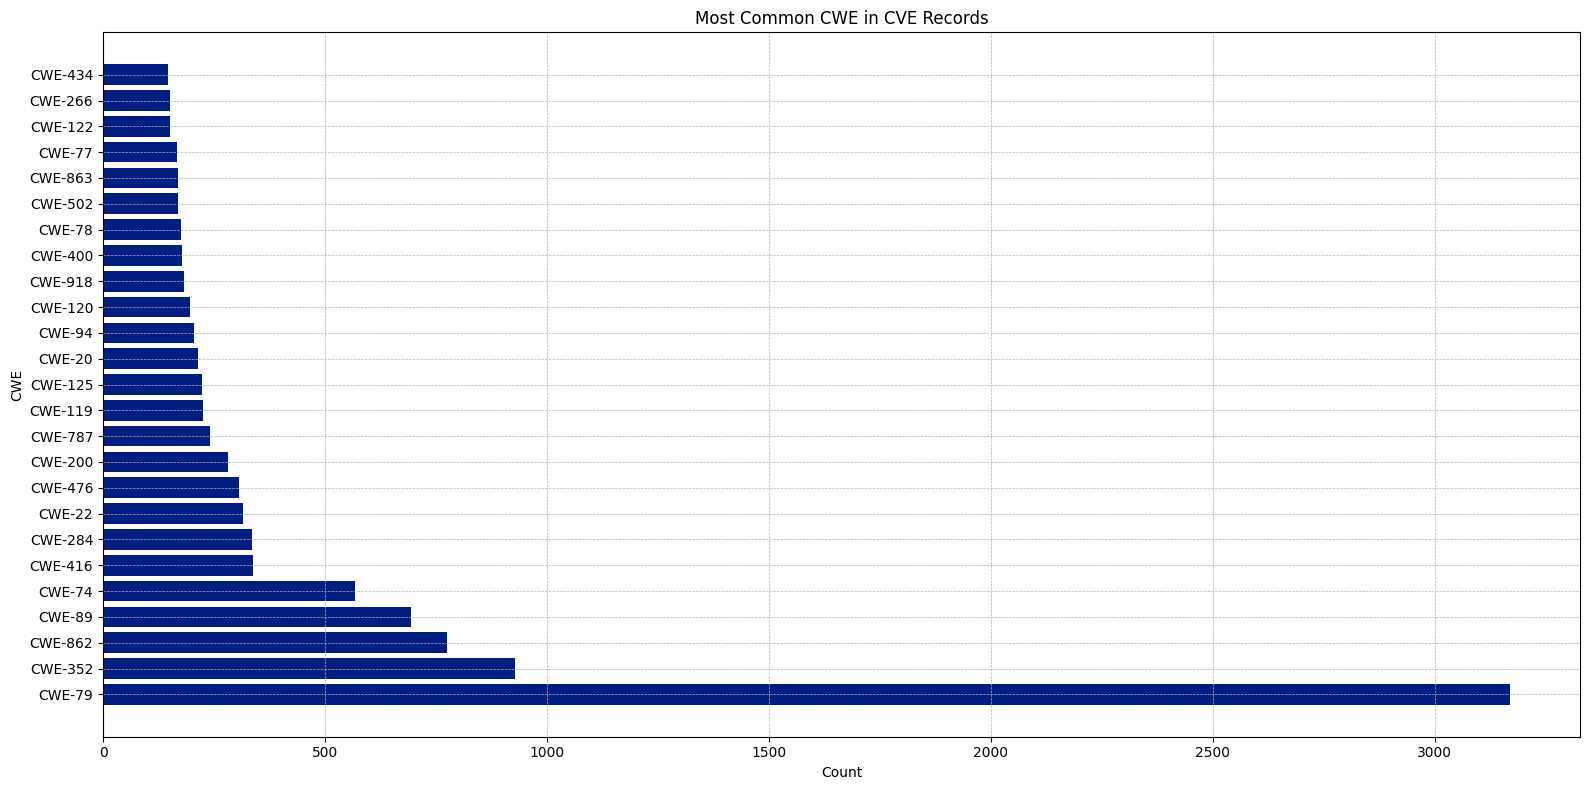

In [19]:
import matplotlib.pyplot as plt

# Calculate frequency of CWEs
nvd_cwe = nvd['CWE'].value_counts().reset_index()
nvd_cwe.columns = ['CWE', 'counts']
nvd_cwe = nvd_cwe[~nvd_cwe.CWE.str.contains('Missing_')]
nvd_cwe = nvd_cwe[nvd_cwe.counts > 20].head(25)

# Plot the most common CWEs
plt.figure(figsize=(16, 8))
plt.barh(nvd_cwe['CWE'], nvd_cwe['counts'], color="#001d82")
plt.xlabel("Count")
plt.ylabel("CWE")
plt.title("Most Common CWE in CVE Records")
plt.grid(True, linestyle='--', linewidth=0.5)

# Adjust layout and show the chart
plt.tight_layout()
plt.show()

In [20]:
Markdown(f"## More CVE Data")

## More CVE Data

In [21]:
Markdown(f"### Top CNA Assigner")

### Top CNA Assigner

In [22]:
nvd_frequency.style.hide()

Assigner,counts
patchstack.com,3298
mitre.org,2007
kernel.org,1633
vuldb.com,1423
wordfence.com,1321
github.com (security-advisories),788
microsoft.com,429
huntr.dev,316
apple.com,290
us.ibm.com,272


In [23]:
Markdown(f"### CVEs By Identifier")

### CVEs By Identifier

In [24]:
years = range(1999, 2025)
cve_counts = []

for year in years:
    count = len(nvd[nvd['CVE'].str.contains(f'CVE-{year}-')])
    if count > 0:
        cve_counts.append({'Year': year, 'Count': count})

cve_df = pd.DataFrame(cve_counts)
cve_df.style.hide(axis='index')

Year,Count
2002,1
2003,1
2015,2
2017,5
2018,19
2019,11
2020,19
2021,60
2022,759
2023,425


In [25]:
Markdown(f"### First 5 CVEs")

### First 5 CVEs

In [26]:
nvd[["CVE", "Description"]].head(5).style.hide()

CVE,Description
CVE-2024-56020,Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting') vulnerability in Mario Di Pasquale SvegliaT Buttons allows Stored XSS.This issue affects SvegliaT Buttons: from n/a through 1.3.0.
CVE-2024-56021,Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting') vulnerability in ibnuyahya Category Post Shortcode allows Stored XSS.This issue affects Category Post Shortcode: from n/a through 2.4.
CVE-2024-11846,"The does not sanitise and escape a parameter before outputting it back in the page, leading to a Reflected Cross-Site Scripting which could be used against high privilege users such as admin"
CVE-2025-0168,A vulnerability classified as critical has been found in code-projects Job Recruitment 1.0. This affects an unknown part of the file /_parse/_feedback_system.php. The manipulation of the argument person leads to sql injection. It is possible to initiate the attack remotely. The exploit has been disclosed to the public and may be used.
CVE-2024-56829,Huang Yaoshi Pharmaceutical Management Software through 16.0 allows arbitrary file upload via a .asp filename in the fileName element of the UploadFile element in a SOAP request to /XSDService.asmx.


In [27]:
Markdown(f"### Last 5 CVEs")

### Last 5 CVEs

In [28]:

nvd[["CVE", "Description"]].tail(5).style.hide()

CVE,Description
CVE-2024-30145,Multiple vectors in HCL Domino Volt and Domino Leap allow client-side script injection in the authoring environment and deployed applications.
CVE-2024-30146,Improper access control of endpoint in HCL Domino Leap allows certain admin users to import applications from the server's filesystem.
CVE-2025-4140,"A vulnerability, which was classified as critical, has been found in Netgear EX6120 1.0.3.94. Affected by this issue is the function sub_30394. The manipulation of the argument host leads to buffer overflow. The attack may be launched remotely. The vendor was contacted early about this disclosure but did not respond in any way."
CVE-2025-4141,"A vulnerability, which was classified as critical, was found in Netgear EX6200 1.0.3.94. This affects the function sub_3C03C. The manipulation of the argument host leads to buffer overflow. It is possible to initiate the attack remotely. The vendor was contacted early about this disclosure but did not respond in any way."
CVE-2025-4142,A vulnerability has been found in Netgear EX6200 1.0.3.94 and classified as critical. This vulnerability affects the function sub_3C8EC. The manipulation of the argument host leads to buffer overflow. The attack can be initiated remotely. The vendor was contacted early about this disclosure but did not respond in any way.
